#### 使用预训练的卷积神经网络

##### 特征提取

In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150,150,3))

In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

最后的特征图形状为(4, 4, 512)。我们将在这个特征上添加一个密集连接分类器。
接下来，下一步有两种方法可供选择。
- 在你的数据集上运行卷积基，将输出保存成硬盘中的Numpy 数组，然后用这个数据作为输入，输入到独立的密集连接分类器中（与本书第一部分介绍的分类器类似）。这种方法速度快，计算代价低，因为对于每个输入图像只需运行一次卷积基，而卷积基是目前流程中计算代价最高的。但出于同样的原因，这种方法不允许你使用数据增强。
- 在顶部添加 Dense 层来扩展已有模型（即 conv_base），并在输入数据上端到端地运行整个模型。这样你可以使用数据增强，因为每个输入图像进入模型时都会经过卷积基。但出于同样的原因，这种方法的计算代价比第一种要高很多。

##### 1. 不使用数据增强的快速特征提取

首先，运行ImageDataGenerator 实例，将图像及其标签提取为Numpy 数组。我们需要
调用conv_base 模型的predict 方法来从这些图像中提取特征。

>使用预训练的卷积基提取特征 

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '../data/cats_and_dogs_small'
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')
test_dir = os.path.join(base_dir,'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count,4,4,512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,
                                           target_size=(150,150),
                                           batch_size=batch_size,
                                           class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i+1) * batch_size] = features_batch
        labels[i * batch_size : (i+1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break #注意：这些生成器在循环生成数据，所以必须要在生成所有图像后终止循环
    return features, labels

train_features, train_labels = extract_features(train_dir,2000)
validation_features, validation_labels = extract_features(validation_dir,1000)
test_features, test_labels = extract_features(test_dir,1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
train_features.shape

(2000, 4, 4, 512)

目前，提取的特征形状为(samples, 4, 4, 512)。我们要将其输入到密集连接分类器中，
所以首先必须将其形状展平为(samples, 8192)

In [6]:
train_features = np.reshape(train_features,(2000,4*4*512))
validation_features = np.reshape(validation_features,(1000,4*4*512))
test_features = np.reshape(test_features,(1000,4*4*512))

train_features.shape

(2000, 8192)

现在你可以定义你的密集连接分类器（注意要使用dropout 正则化），并在刚刚保存的数据
和标签上训练这个分类器。

In [7]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim= 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(train_features,train_labels,
                   epochs=30,
                   batch_size=20,
                   validation_data=(validation_features,validation_labels))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5789 - acc: 0.6930 - val_loss: 0.4207 - val_acc: 0.8460
Epoch 2/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.4194 - acc: 0.8155 - val_loss: 0.3636 - val_acc: 0.8480
Epoch 3/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.3584 - acc: 0.8450 - val_loss: 0.3207 - val_acc: 0.8850
Epoch 4/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.3012 - acc: 0.8795 - val_loss: 0.2961 - val_acc: 0.8870
Epoch 5/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2881 - acc: 0.8820 - val_loss: 0.2826 - val_acc: 0.8890
Epoch 6/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2654 - acc: 0.8955 - val_loss: 0.2728 - v

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


我们来看一下训练期间的损失曲线和精度曲线

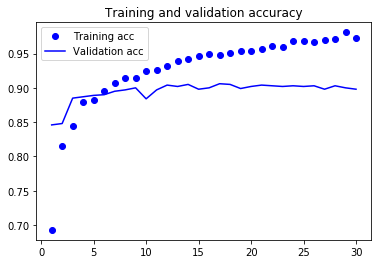

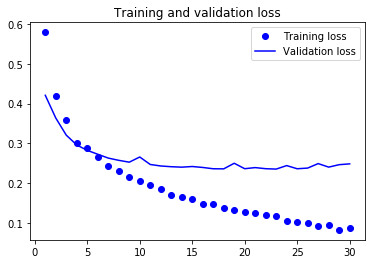

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

我们的验证精度达到了约90%，比上一节从头开始训练的小型模型效果要好得多。但从图
中也可以看出，虽然dropout 比率相当大，但模型几乎从一开始就过拟合。这是因为本方法没有
使用数据增强，而数据增强对防止小型图像数据集的过拟合非常重要。

##### 2.使用数据增强的特征提取

下面我们来看一下特征提取的第二种方法，它的速度更慢，计算代价更高，但在训练期间
可以使用数据增强。这种方法就是：扩展conv_base 模型，然后在输入数据上端到端地运行模型。
> 注意 本方法计算代价很高，只在有GPU 的情况下才能尝试运行。它在CPU 上是绝对难以运
行的。如果你无法在GPU 上运行代码，那么就采用第一种方法。

模型的行为和层类似，所以你可以向Sequential 模型中添加一个模型（比如conv_base），
就像添加一个层一样。

In [11]:
model2 = models.Sequential()
model2.add(conv_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))


In [12]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [13]:
print('This is the number of trainable weights before freezing the conv base:',
     len(model2.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [14]:
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:',
     len(model2.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


现在你可以开始训练模型了，使用和前一个例子相同的数据增强设置。

In [15]:

train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)# 注意:不能增强验证数据



In [ ]:
train_generator = train_datagen.flow_from_directory(train_dir,#目标目录
                                                   target_size=(150,150),#将所有图像的大小调整为150X150
                                                   batch_size=20,
                                                   class_mode='binary')#因为使用了binary_crossentropy损失，所以要用二进制标签

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                       target_size=(150,150),
                                                       batch_size=20,
                                                       class_mode='binary')

model2.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=2e-5),
             metrics=['acc'])

history2 = model2.fit_generator(train_generator,
                               steps_per_epoch=100,
                               epochs=30,
                               validation_data=validation_generator,
                               validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 381s 4s/step - loss: 0.5971 - acc: 0.6930 - val_loss: 0.4683 - val_acc: 0.8220
Epoch 2/30
100/100 [==============================] - 379s 4s/step - loss: 0.4871 - acc: 0.7875 - val_loss: 0.3808 - val_acc: 0.8530
Epoch 3/30
100/100 [==============================] - 383s 4s/step - loss: 0.4359 - acc: 0.8110 - val_loss: 0.3339 - val_acc: 0.8740
Epoch 4/30
100/100 [==============================] - 384s 4s/step - loss: 0.4083 - acc: 0.8320 - val_loss: 0.3152 - val_acc: 0.8710
Epoch 5/30
100/100 [==============================] - 380s 4s/step - loss: 0.3887 - acc: 0.8415 - val_loss: 0.2975 - val_acc: 0.8830
Epoch 6/30
100/100 [==============================] - 394s 4s/step - loss: 0.3867 - acc: 0.8230 - val_loss: 0.2853 - val_acc: 0.8880
Epoch 7/30
100/100 [==============================] - 395s 4s/step - loss: 0.3498 - acc: 0.8560 - val_loss: 0.2801 - v